In [1]:
from src.rejax.envs.bernoulli_bandit import BernoulliBandit, EnvParams
from rejax import get_algo
from rejax.evaluate import evaluate

import jax
import jax.numpy as jnp
import numpy as np
import yaml

In [2]:
config_path = "/Users/chanb/research/ualberta/sandbox/rejax/configs/custom/bandit.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [3]:
algo_name = "ucb"
seed_id = 0
num_seeds = 3
num_arms = 5

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'confidence': 1.0},
 'total_timesteps': 100000,
 'eval_freq': 1000}

In [5]:
env = BernoulliBandit()
config["env"] = env

env_params = jax.random.uniform(key, shape=(num_seeds, num_arms))

algo_cls = get_algo(algo_name)
algo = jax.vmap(
    lambda x: algo_cls.create(
        **config,
        env_params=EnvParams(reward_probs=x),
    )
)(
    env_params
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 200, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
algo

UCB(env=<src.rejax.envs.bernoulli_bandit.BernoulliBandit object at 0x1488816f0>, env_params=EnvParams(max_steps_in_episode=Array([1, 1, 1], dtype=int32, weak_type=True), reward_probs=Array([[0.947667  , 0.9785799 , 0.33229148, 0.46866846, 0.5698887 ],
       [0.16550303, 0.3101946 , 0.68948054, 0.74676657, 0.17101455],
       [0.9853538 , 0.02528262, 0.6400418 , 0.56269085, 0.8992138 ]],      dtype=float32)), eval_callback=<function eval_callback at 0x11de08310>, eval_freq=1000, skip_initial_evaluation=False, total_timesteps=100000, learning_rate=Array([0.0003, 0.0003, 0.0003], dtype=float32, weak_type=True), gamma=Array([0.99, 0.99, 0.99], dtype=float32, weak_type=True), max_grad_norm=Array([inf, inf, inf], dtype=float32, weak_type=True), num_envs=1, agent=TabularUCB(
    # attributes
    num_arms = 5
    confidence = 1.0
))

In [7]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

print(None)

None


In [8]:
jax.vmap(lambda x: jax.numpy.mean(x, axis=-1)[-1])(returns)

Array([0.96999997, 0.72999996, 0.995     ], dtype=float32)

In [9]:
np.argmax(env_params, axis=-1)

Array([1, 3, 0], dtype=int32)

In [10]:
np.argmax(ts.agent_ts.params["params"]["counts"], axis=-1).T

Array([[1, 3, 0]], dtype=int32)

In [11]:
np.argmax(ts.agent_ts.params["params"]["q_values"], axis=-1).T

Array([[1, 3, 0]], dtype=int32)

In [12]:
jax.debug.print("{x}", x=ts.agent_ts.params)

{'params': {'counts': Array([[[9.7890e+03, 8.9950e+04, 3.6000e+01, 8.5000e+01, 1.4000e+02]],

       [[5.9000e+01, 1.3000e+02, 4.3500e+03, 9.5391e+04, 7.0000e+01]],

       [[9.7696e+04, 2.4000e+01, 1.6600e+02, 1.3400e+02, 1.9800e+03]]],      dtype=float32), 'q_values': Array([[[0.9463641 , 0.9788759 , 0.19444446, 0.47058836, 0.5857143 ]],

       [[0.13559319, 0.3384616 , 0.68942463, 0.7467705 , 0.18571427]],

       [[0.9842423 , 0.        , 0.62650615, 0.58208954, 0.8914142 ]]],      dtype=float32), 'timesteps': Array([100000., 100000., 100000.], dtype=float32)}}


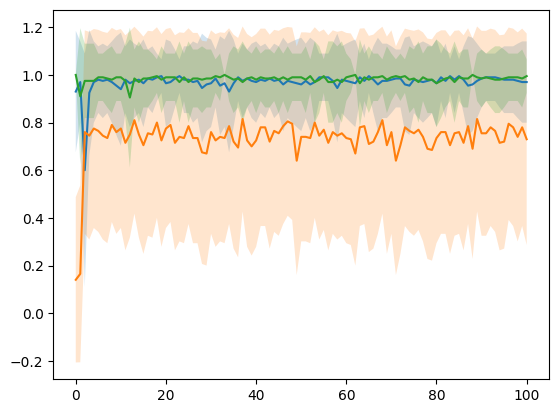

In [13]:
import matplotlib.pyplot as plt

for env_returns in returns:
    xrange = np.arange(len(env_returns))
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1)
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
